In [56]:
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
import numpy as np
from sklearn import svm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

In [2]:
train = pd.read_csv("../data/X_train.csv").drop('id', axis=1)
test = pd.read_csv("../data/X_test.csv").drop('id', axis=1)
y = pd.read_csv("../data/y_train.csv").y

In [69]:
scaler = MinMaxScaler().fit(train)
train_ = scaler.transform(train)
train_ = pd.DataFrame(train_, columns=train.columns)
test_ = scaler.transform(test)
test_ = pd.DataFrame(test_, columns=train.columns)
train_.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x990,x991,x992,x993,x994,x995,x996,x997,x998,x999
0,0.338184,0.664250,0.431693,0.579132,0.578488,0.570850,0.487067,0.633250,0.621341,0.949429,...,0.471261,0.624875,0.466546,0.430609,0.996549,0.157947,0.264661,0.774912,0.121426,0.799894
1,0.610549,0.667054,0.645002,0.486750,0.553779,0.526908,0.586008,0.620548,0.325302,0.395117,...,0.544796,0.339638,0.629951,0.613613,0.234317,0.656230,0.594312,0.183105,0.420897,0.492220
2,0.463301,0.355687,0.635316,0.565582,0.628131,0.477085,0.667413,0.603458,0.446381,0.440196,...,0.484671,0.324740,0.621342,0.484725,0.330405,0.757357,0.698897,0.331881,0.459106,0.356669
3,0.695373,0.348353,0.513262,0.399802,0.407534,0.315622,0.585988,0.471186,0.520312,0.577067,...,0.637487,0.571298,0.486050,0.447050,0.408222,0.384105,0.483214,0.437730,0.345946,0.627880
4,0.489418,0.384571,0.707125,0.274745,0.439208,0.427623,0.618922,0.452765,0.264217,0.325817,...,0.490300,0.157076,0.642916,0.551484,0.429834,0.608952,0.652230,0.284299,0.378540,0.452769


In [ ]:
# Get balanced accuracy score
def score(true, pred):
    return balanced_accuracy_score(true, pred)

# Oversample using SMOTE
def oversample(x_data, y_data):
    smote = SMOTE(ratio='not majority', random_state=42)
    return smote.fit_sample(x_data, y_data)

# Oversample and fit model for a CV split
def run_fold(x_train, y_train, x_test, y_test, model):
    # Oversample data
    #x_train_sm, y_train_sm = oversample(x_train, y_train)
    x_train_sm, y_train_sm = x_train, y_train
    # Fit model
    model.fit(x_train_sm, y_train_sm)
    y_train_pred = model.predict(x_train_sm)
    train_score = score(y_train_sm, y_train_pred)
    y_test_pred = model.predict(x_test)
    test_score = score(y_test, y_test_pred)
    return test_score, train_score

def cross_validate(x_data, y_data, model, variable):
    # Split data into folds
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = kf.split(x_data)
    test_scores = []
    train_scores = []
    times = []
    split = 0
    for train_index, test_index in folds:
        split += 1
        #print('Running split {}/{}'.format(split, n_splits))
        x_train = x_data[train_index]
        y_train = y_data[train_index]
        x_test = x_data[test_index]
        y_test = y_data[test_index]
        start_time = time.time()
        test_score, train_score = run_fold(x_train, y_train, x_test, y_test, model)
        end_time = time.time()
        total_time = round(end_time-start_time, ndigits=0)
        test_scores.append(test_score)
        train_scores.append(train_score)
        times.append(end_time-start_time)
        #print('Test score = {}\nTrain score = {}\nTime = {}s\n'.format(test_score, train_score, total_time))
    print('Average test score: {}\nAverage train score: {}\nTotal time: {}s'.format(np.mean(test_scores), np.mean(train_scores), np.sum(times)))
    return test_scores, train_scores, times

In [ ]:
def cross_validate_pca(x_data, y_data, model, i):
    # Split data into folds
    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = kf.split(x_data)
    test_scores = []
    train_scores = []
    times = []
    split = 0
    for train_index, test_index in folds:
        split += 1
        #print('Running split {}/{}'.format(split, n_splits))
        x_train = x_data[train_index]
        y_train = y_data[train_index]
        x_test = x_data[test_index]
        y_test = y_data[test_index]
        pca = PCA(n_components = np.round(i,2))
        pca.fit(pd.concat([pd.DataFrame(x_train),pd.DataFrame(x_test)]).values) 
        x_train_ = pd.DataFrame(pca.transform(x_train))
        x_test_ = pd.DataFrame(pca.transform(x_test))
        start_time = time.time()
        test_score, train_score = run_fold(x_train_, y_train, x_test_, y_test, model)
        end_time = time.time()
        total_time = round(end_time-start_time, ndigits=0)
        test_scores.append(test_score)
        train_scores.append(train_score)
        times.append(end_time-start_time)
        #print('Test score = {}\nTrain score = {}\nTime = {}s\n'.format(test_score, train_score, total_time))
    print('Average test score: {}\nAverage train score: {}\nTotal time: {}s'.format(np.mean(test_scores), np.mean(train_scores), np.sum(times)))
    return test_scores, train_scores, times

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
test_scores, train_scores, times = cross_validate(train_.values, y.ravel(), rf)

In [ ]:
poly = PolynomialFeatures(2,interaction_only = True)
poly = poly.fit(pd.concat([train_,test_]).values)

In [ ]:
poly_tr = pd.DataFrame(poly.transform(train_))
poly_ts = pd.DataFrame(poly.transform(test_))

In [ ]:
poly_tr.shape

### PCA

In [112]:
pca = PCA(n_components = .844)
pca.fit(train_.values)  
len(pca.explained_variance_ratio_)
# pca = PCA(n_components = 0.8)
# pca.fit(pd.concat([poly_tr,poly_ts]).values)  
# len(pca.explained_variance_ratio_)

281

In [84]:
components = pca.transform(train_)
components_df = pd.DataFrame(components)

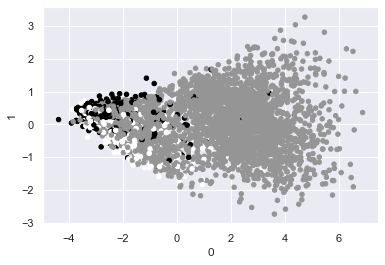

In [85]:
components_df.iloc[:,0:2].plot.scatter(x=0,y=1,c=y)

In [ ]:
def scores_pca(tr,ts,y,clf):
    test_scores = list()
    train_scores = list()
    times_iters = list()
    for i in np.arange(0.7,0.9,0.01,dtype=float):
        print('Start of {}'.format(np.round(i,2)))
        test_scores, train_scores, times = cross_validate_pca(tr.values, y.ravel(), clf, i)
        test_scores.append(np.mean(test_scores))
        train_scores.append(np.mean(train_scores))
        times_iters.append(np.sum(times))
        print('End of {}, time: {}s'.format(np.round(i,2),np.sum(times)))
    return test_scores, train_scores, times_iters

In [ ]:
clf = svm.SVC(gamma = 'scale' ,kernel = 'rbf', decision_function_shape='ovo', cache_size=3000, random_state = 42, class_weight = 'balanced')

In [ ]:
test_scores, train_scores, times_iters = scores_pca(train_,test_,y,clf)
# Start of 0.79
# Average test score: 0.7058763831465686
# Average train score: 0.8430579667389339
# Total time: 139.4414963722229s

### Grid Search CV

In [77]:
1/(len(train.columns)+ train.values.var())

0.0009991676539366876

In [172]:
C1 = [np.round(i,4) for i in np.arange(0.101,0.103,0.0001)]
C2 = [np.round(i,4) for i in np.arange(0.931, 0.95,0.0001)]
C3 = [np.round(i,6) for i in np.arange(0.00038,0.00039,0.000001)]

In [174]:
pipe_steps1 = [('scaler', StandardScaler()), ('pca',PCA()), ('SVM', svm.SVC(kernel = 'poly', gamma='scale',
                                                                decision_function_shape='ovo',
                                                                cache_size=3000, random_state = 42,
                                                                class_weight = 'balanced'))]
pipeline1 = Pipeline(pipe_steps1)

check_params1 = {
    'pca__n_components':[0.8435],
    'SVM__C': C1,
    'SVM__degree': [3],
    'SVM__coef0': [1]
    #'SVM__gamma':np.logspace(-9, -3, 6)
}

# Best fit
# {'SVM__C': 0.102, 'SVM__coef0': 1, 'SVM__degree': 3, 'pca__n_components': 0.8435}
# 0.7050925925925926

In [175]:
pipe_steps2 = [('scaler', MinMaxScaler()), ('pca',PCA()), ('SVM', svm.SVC(kernel = 'rbf', gamma='scale',
                                                                decision_function_shape='ovo',
                                                                cache_size=3000, random_state = 42,
                                                                class_weight = 'balanced'))]
pipeline2 = Pipeline(pipe_steps2)

check_params2 = {
    'pca__n_components':[0.8],
    'SVM__C': C2
    #'SVM__gamma':np.logspace(-9, -3, 6)
}
# Best fit
# {'SVM__C': 0.9461, 'pca__n_components': 0.8}
# 0.7047222222222222

In [163]:
pipe_steps3 = [('scaler', StandardScaler()), ('pca',PCA()), ('SVM', LinearSVC(random_state = 42,
                                                                multi_class= 'crammer_singer', max_iter=3000,
                                                                class_weight = 'balanced'))]
pipeline3 = Pipeline(pipe_steps3)

check_params3 = {
    'pca__n_components':[0.8],
    'SVM__C': C3,
    'SVM__fit_intercept': [False]
    #'SVM__gamma':np.logspace(-9, -3, 6)
}

In [176]:
#cross_values = cross_val_score
create_grid=GridSearchCV(pipeline1, check_params1,cv=8, scoring='balanced_accuracy', n_jobs=-1, verbose=2)
create_grid.fit(train,y)
print("Best fit")
#print(cross_values.mean())
#print(cross_values)
print(create_grid.best_params_)
print(create_grid.best_score_)

Fitting 8 folds for each of 20 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  9.0min finished


Best fit
{'SVM__C': 0.102, 'SVM__coef0': 1, 'SVM__degree': 3, 'pca__n_components': 0.8435}
0.7050925925925926


In [177]:
#cross_values = cross_val_score
create_grid=GridSearchCV(pipeline2, check_params2,cv=8, scoring='balanced_accuracy', n_jobs=-1, verbose=2)
create_grid.fit(train,y)
print("Best fit")
#print(cross_values.mean())
#print(cross_values)
print(create_grid.best_params_)
print(create_grid.best_score_)

Fitting 8 folds for each of 190 candidates, totalling 1520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done 1520 out of 1520 | elapsed: 71.7min finished


Best fit
{'SVM__C': 0.9461, 'pca__n_components': 0.8}
0.7047222222222222


In [166]:
#cross_values = cross_val_score
create_grid=GridSearchCV(pipeline3, check_params3,cv=8, scoring='balanced_accuracy', n_jobs=-1, verbose=2)
create_grid.fit(train,y)
print("Best fit")
#print(cross_values.mean())
#print(cross_values)
print(create_grid.best_params_)
print(create_grid.best_score_)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   54.3s finished


Best fit
{'SVM__C': 0.000389, 'SVM__fit_intercept': False, 'pca__n_components': 0.8}
0.6905555555555555


In [32]:
print(create_grid.best_score_,create_grid.best_params_)
# 0.7015740740740742 {'SVM__C': 1, 'SVM__gamma': 0.001}
# 0.6973148148148148 {'SVM__C': 0.630957344480193, 'SVM__gamma': 0.001}

0.6973148148148148 {'SVM__C': 0.630957344480193, 'SVM__gamma': 0.001}


In [ ]:
clf = svm.SVC(gamma = 'scale' ,kernel = 'rbf', decision_function_shape='ovo', cache_size=3000, random_state = 42, class_weight = 'balanced')
test_scores, train_scores, times = cross_validate(components_df.values, y.ravel(), clf)

#WITH OVERSAMPLING
# SVM 240 PCs (80.x%)
# Average test score: 0.6624038730845622
# Average train score: 0.9343450326600132
# Total time: 493.02259135246277s
# SVM PCs (90%)
# Average test score: 0.649990375723468
# Average train score: 0.9632699801869032
# Total time: 975.6408638954163s
# SVM 200 PCs (<80%)
# Average test score: 0.6607910083259538
# Average train score: 0.9231407317122418
# Total time: 410.38625621795654s
# SVM 238 PCs (80%)
# Average test score: 0.6625778192190811
# Average train score: 0.9326657068920167
# Total time: 489.1878070831299s

#WITH CLASS WEIGHTS
#80%
# Average test score: 0.6980772066781805
# Average train score: 0.8506625620915867
# Total time: 172.54561042785645s
#70%
# Average test score: 0.6946741811444423
# Average train score: 0.8101701484126517
# Total time: 80.19191813468933s
#75%
# Average test score: 0.6987988339325073
# Average train score: 0.8314035482105762
# Total time: 115.05265045166016s

In [37]:
# x_ov, y_ov = oversample(components_df, y)
# clf.fit(x_ov, y_ov)
clf = svm.SVC(C=1,gamma = 0.001 ,kernel = 'rbf', decision_function_shape='ovo', cache_size=3000, random_state = 42, class_weight = 'balanced')
clf.fit(components_df.values, y.ravel())

SVC(C=1, cache_size=3000, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [77]:
pipe_steps = [('scaler', StandardScaler()),  ('pca',PCA(n_components=0.79)),
              ('GAUSS', GaussianProcessClassifier(n_restarts_optimizer=1,multi_class='one_vs_one',max_iter_predict =500))]
pipeline = Pipeline(pipe_steps)

In [78]:
cv_scores = cross_val_score(pipeline, train, y, cv=10, scoring='balanced_accuracy',n_jobs =-1)
print("Test-CV set score: {:0.5f} ".format(cv_scores.mean()))

Test-CV set score: 0.57546 


In [58]:
cv_scores
# 1 elastic net LASSO
# Test-CV set score: 0.67370 
# array([0.64259259, 0.64351852, 0.675     , 0.67407407, 0.67962963,
#        0.70185185, 0.67037037, 0.68611111, 0.68148148, 0.68240741])
# 0.5 elastic net
# Test-CV set score: 0.67139 
# array([0.64259259, 0.64444444, 0.675     , 0.67592593, 0.67962963,
#        0.69074074, 0.67037037, 0.68703704, 0.67592593, 0.67222222])
# 0 elastic net RIDGE
# Test-CV set score: 0.66824 
# array([0.64259259, 0.64351852, 0.65833333, 0.67037037, 0.67962963,
#        0.68981481, 0.66574074, 0.68333333, 0.67685185, 0.67222222])

array([0.64259259, 0.64444444, 0.675     , 0.675     , 0.67962963,
       0.6962963 , 0.67037037, 0.68611111, 0.67592593, 0.68240741])

In [ ]:
def plot_contours(ax, clf_, xx, yy, **params):
    Z = np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(236)]).T
    Z = clf_.predict(Z).reshape(xx.shape) 
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.1):
    x_min, x_max = x.min() - 1 , x.max() + 1
    y_min, y_max = y.min() - 1 , y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    return xx, yy


In [ ]:
X0 = np.array(components_df.iloc[:,0])
X1 = np.array(components_df.iloc[:,1])
xx, yy = make_meshgrid(X0,X1)
len(xx.ravel())

In [ ]:
X0 = np.array(components_df.iloc[:,0])
X1 = np.array(components_df.iloc[:,1])
xx, yy = make_meshgrid(X0,X1)

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_facecolor('white')
cdict1={0:'lime',1:'deeppink', 2:'purple'}

Y_tar_list = y.tolist()
labels1 = Y_tar_list

labl1 = {0:'0', 1:'1', 2:'2'}
marker1= {0:'*',1:'d',2:'h'}
alpha1={0:.6, 1:0.3, 2:0.6}

for l1 in np.unique(labels1):
    ix1 = np.where(labels1==l1)
    ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1], label=labl1[l1],s=70, 
               marker=marker1[l1], alpha=alpha1[l1])

ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=40,
          facecolors='none', edgecolors='navy', label='Support Vectors', alpha=0.5)

plot_contours(ax, classify, xx, yy, cmap='seismic', alpha=0.4)
plt.legend(fontsize=15)

plt.xlabel("1st Principal Component", fontsize=14)
plt.ylabel("2nd Principal Component", fontsize=14)

plt.show()

### TEST file

In [180]:
scaler = StandardScaler().fit(train)
train_ = scaler.transform(train)

pca = PCA(n_components = 0.8435)
pca.fit(train_)  
components = pca.transform(train_)
components_df = pd.DataFrame(components)

clf = svm.SVC(kernel = 'poly', gamma='scale', degree= 3, coef0= 1,
                decision_function_shape='ovo', C = 0.102,
                cache_size=3000, random_state = 42,
                class_weight = 'balanced')

clf.fit(components_df, y)

test_ = scaler.transform(test)
components = pca.transform(test_)
components_test = pd.DataFrame(components)
test_y = clf.predict(components_test)
file_test = "svm_poly"

In [182]:
scaler = MinMaxScaler().fit(train)
train_ = scaler.transform(train)

pca = PCA(n_components = 0.8)
pca.fit(train_)  
components = pca.transform(train_)
components_df = pd.DataFrame(components)

clf = svm.SVC(kernel = 'rbf', gamma='scale', C=0.9461,
                decision_function_shape='ovo',
                cache_size=3000, random_state = 42,
                class_weight = 'balanced')
clf.fit(components_df, y)


test_ = scaler.transform(test)
components = pca.transform(test_)
components_test = pd.DataFrame(components)
test_y = clf.predict(components_test)
file_test = "svm_rbf"

In [186]:
scaler = StandardScaler().fit(train)
train_ = scaler.transform(train)

pca = PCA(n_components = 0.8)
pca.fit(train_)  
components = pca.transform(train_)
components_df = pd.DataFrame(components)

clf = LinearSVC(random_state = 42, C= 0.000389, fit_intercept =False,
            multi_class= 'crammer_singer', max_iter=3000, class_weight = 'balanced')
clf.fit(components_df, y)

test_ = scaler.transform(test)
components = pca.transform(test_)
components_test = pd.DataFrame(components)
test_y = clf.predict(components_test)
file_test = "svm_linear"

In [205]:
output = pd.DataFrame({'id':[float(i) for i in range(0,len(test_y))],'y':test_y})
output.to_csv("{}.csv".format(file_test),index=False)

In [190]:
df1 = pd.read_csv("svm_linear.csv").drop('id',axis=1)
df2 = pd.read_csv("svm_poly.csv").drop('id',axis=1)
df3 = pd.read_csv("svm_rbf.csv").drop('id',axis=1)

In [192]:
df_all = pd.concat([df1,df2,df3],axis=1)
df_all.head()

,y,y,y
0,1,1,1
1,2,0,0
2,1,1,1
3,2,2,2
4,1,1,1


In [202]:
def major_voting(row):
    dict_ = {}
    values = row.values
    dict_[values[0]] = 1
    for i in range(1,3):
        if values[i] in dict_.keys():
            dict_[values[i]] += 1
        else:
            dict_[values[i]] = 1
    return int(max(dict_, key=dict_.get))

In [204]:
test_y = df_all.apply(major_voting,axis=1)
file_test = "ensemble"